# Data Engineering Immersion Day

In this lab you will learn how to load you data from S3 into the notebook and create a forecast prediction on this data utilizing a target series data set as well as a related series data set. For more information and examples please visit the following [github repo](https://github.com/aws-samples/amazon-forecast-samples)

**Outline**

1. Get your data
2. Clean your data
3. Create a datasetgroup for Forecast
4. Create a predictor based on the dataset group
5. Create a forecast leveraging the predictor
6. Validate your forecast



In [2]:
# We are importing a couple dependencies 

import boto3
from time import sleep
import subprocess
import pandas as pd
import json
import time
import pprint
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates

This configuration will make our graphs scale good

In [3]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (20,10)

Defining a local directory

In [4]:
data_dir = "data"
!mkdir $data_dir

mkdir: cannot create directory ‘data’: File exists


## Obtaining Source Data:

The goal here is to explore the data we got from DMS into S3

In [7]:
# Defining some variables

datasource_s3bucket = "dmslab-student-luseloso-dmslabs3bucket-h54huljrwheu"
# datasource_s3bucket = "ENTER YOUR S3 BUCKET HERE YOU CAN FIND THIS IN THE OUTPUTS SECTION OF THE CFN TEMPLATE"

s3 = boto3.resource('s3')
poc_bucket = s3.Bucket(datasource_s3bucket)
dms_import_files = list(poc_bucket.objects.filter(Prefix="athenaquery"))
for file in dms_import_files:
    #There will be a collection of CSVs if the forecast is large, modify this to go get them all
    if "csv" in file.key:
        print(file)
        if not "metadata" in file.key:
            dms_filename = file.key.split('/')[4]
            s3.Bucket(datasource_s3bucket).download_file(file.key, data_dir+"/"+dms_filename)
print(dms_filename)


s3.ObjectSummary(bucket_name='dmslab-student-luseloso-dmslabs3bucket-h54huljrwheu', key='athenaquery/2020/02/19/a9098c00-499c-4509-961e-fd41e6fcea30.csv')
s3.ObjectSummary(bucket_name='dmslab-student-luseloso-dmslabs3bucket-h54huljrwheu', key='athenaquery/2020/02/19/a9098c00-499c-4509-961e-fd41e6fcea30.csv.metadata')
a9098c00-499c-4509-961e-fd41e6fcea30.csv


In [341]:
f = pd.read_csv(data_dir+"/"+dms_filename)
f.describe()

,ticket_id,event_id,seat_level,seat_section,seat,ticket_price
count,8.808770e+05,880877.000000,880877.000000,880877.000000,880877.000000,880877.000000
mean,5.225196e+07,6903.712853,2.350242,28.304662,2.004313,52.941284
std,6.256357e+07,3513.908253,0.558494,19.254517,0.879596,24.198662
min,1.039110e+05,71.000000,2.000000,1.000000,1.000000,19.470000
25%,7.061671e+06,3661.000000,2.000000,13.000000,1.000000,35.420000
50%,1.239156e+07,7691.000000,2.000000,26.000000,2.000000,43.350000
75%,1.437027e+08,10131.000000,3.000000,41.000000,3.000000,69.000000
max,1.500341e+08,11571.000000,4.000000,94.000000,4.000000,148.050000


Now lets plot this data to see how it looks

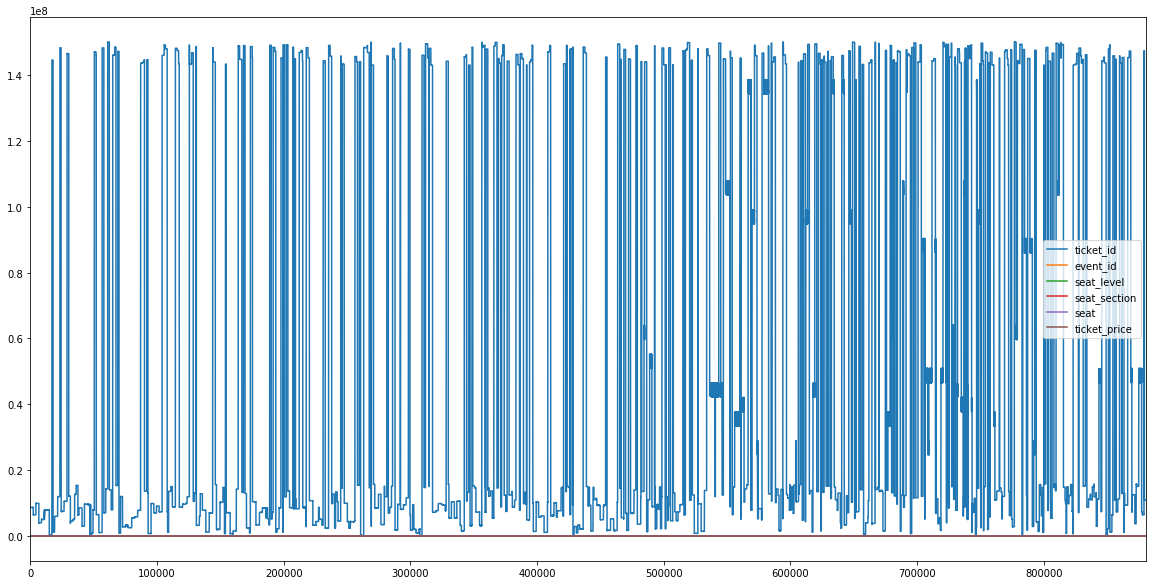

In [93]:
f.plot()

### We need to clean some of this data

Here we are copying our file contents into a ticket dataframe, dropping most columns, then we are going to add a new column with the count of tickets sold per week

In [347]:
ticket_df = f.copy()
#Dropping most columns
ticket_df = ticket_df[['event_date_time']]
#Transforming time into datetime
ticket_df['event_date_time'] = pd.to_datetime(ticket_df['event_date_time'])
#Creating a new column
s = ticket_df.columns.to_series().sample(len(ticket_df),replace = True)
ticket_df['ticket_count']=ticket_df.lookup(ticket_df.index,s)
#Grouping the ticket count per hour
ticket_df = ticket_df.groupby(pd.Grouper(key='event_date_time', freq='H')).count().dropna()

Plotting our data for visualization pusposes

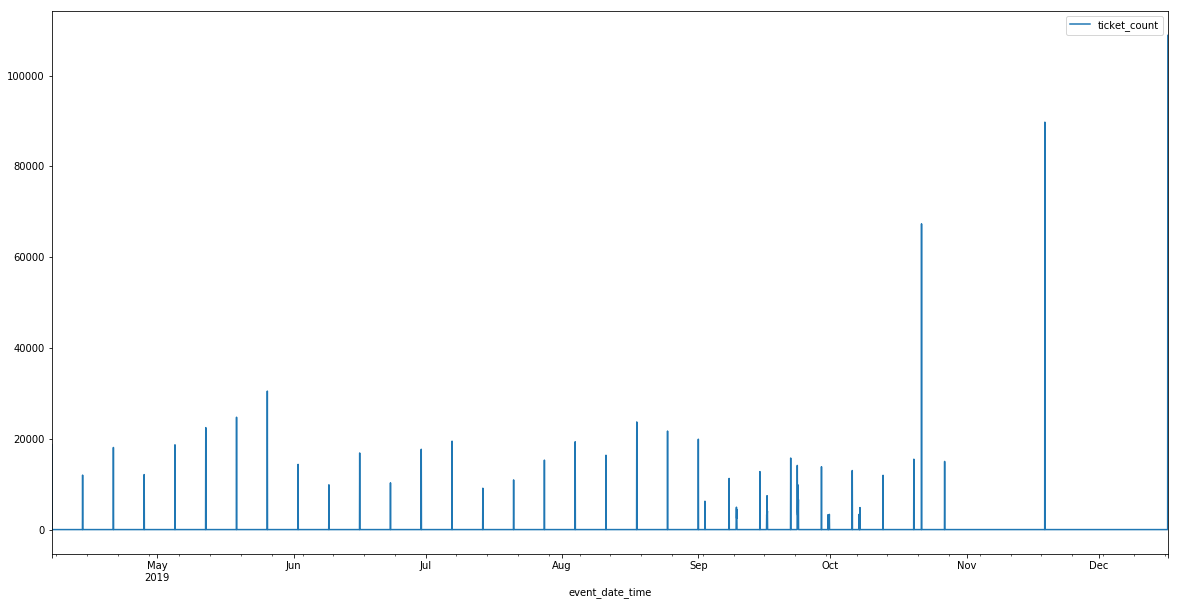

In [348]:
ticket_df.plot()

Now we can take a look at some statistics of our data frame

In [349]:
ticket_df.describe()

,ticket_count
count,6091.000000
mean,144.619439
std,2357.757237
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,108855.000000


In [350]:
ticket_df.replace(0, np.nan, inplace=True)
ticket_df = ticket_df.interpolate(method='linear')


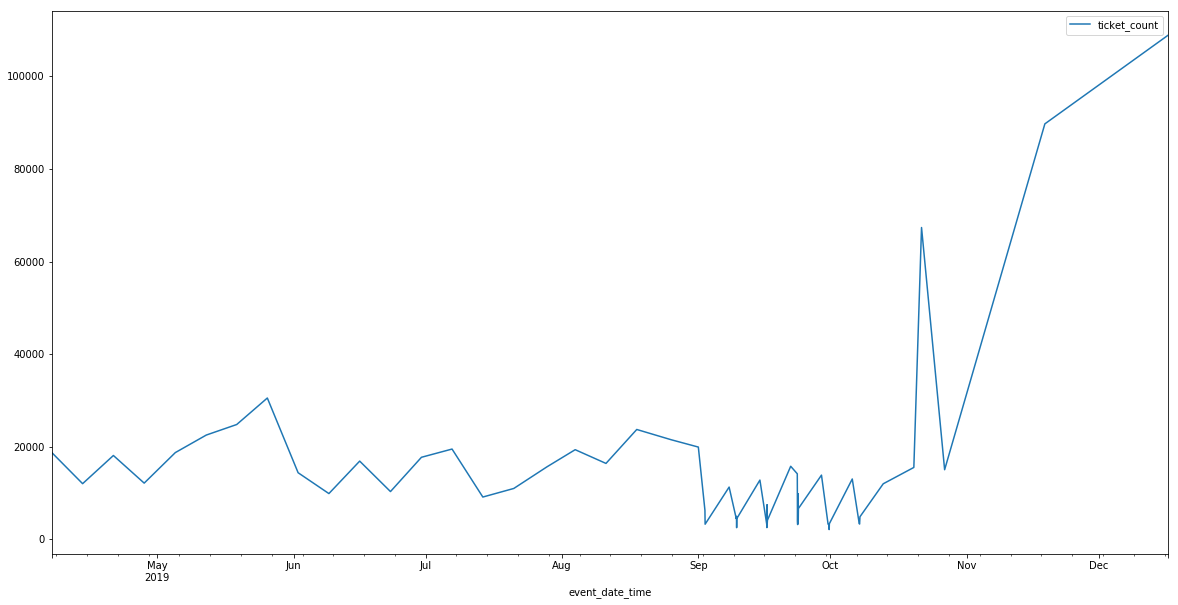

In [351]:
ticket_df.plot()

In [282]:
ticket_df.describe()

,ticket_count
count,6091.000000
mean,28659.834017
std,28579.070873
min,2080.000000
25%,12567.241071
50%,17217.428571
75%,24633.491071
max,108855.000000


## Building Data Files

Knowing that our above dataframe `ticket_df` covers the entire time period we care about in this case 32 weeks. We are going to restrict it to feed all this data for training and then predict an aditional 3 weeks.

In [283]:
#Create a copy
target_df = ticket_df.copy()

In [284]:
target_time_series_df = target_df.copy()
#Validate the data range
print (target_time_series_df.index.min())
print (target_time_series_df.index.max())
print (target_time_series_df.describe())

2019-04-07 00:00:00
2019-12-16 18:00:00
        ticket_count
count    6091.000000
mean    28659.834017
std     28579.070873
min      2080.000000
25%     12567.241071
50%     17217.428571
75%     24633.491071
max    108855.000000


Let's make sure that we arent missing any hour between 2019-04-07 00:00:00 and 2019-12-16 18:00:00 by checking WolframAlpha https://www.wolframalpha.com/input/?i=+how+many+hours+between+2019-04-07+00%3A00%3A00+and+2019-12-16+18%3A00%3A00

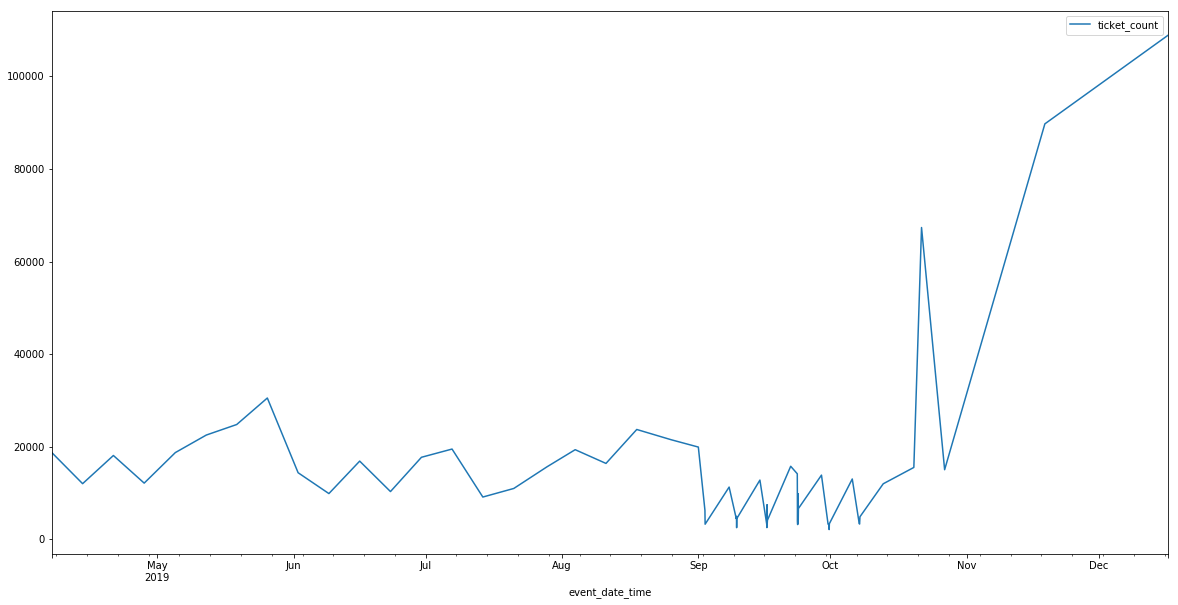

In [285]:
target_time_series_df.plot()

Now that we verified our range in the data frame lets start cleaning the data for a format supported by Forecast

In [286]:
target_time_series_df.tail(10)

,ticket_count
event_date_time,
2019-12-16 09:00:00,108598.627422
2019-12-16 10:00:00,108627.113264
2019-12-16 11:00:00,108655.599106
2019-12-16 12:00:00,108684.084948
2019-12-16 13:00:00,108712.570790
2019-12-16 14:00:00,108741.056632
2019-12-16 15:00:00,108769.542474
2019-12-16 16:00:00,108798.028316
2019-12-16 17:00:00,108826.514158


In [287]:
target_time_series_df = target_time_series_df.loc['2019-04-07 00:00:00':]
#Add in item_id
target_time_series_df['item_ID'] = "Hourly_Ticket_Count"
#validate the structure
target_time_series_df.tail(10)

,ticket_count,item_ID
event_date_time,,
2019-12-16 09:00:00,108598.627422,Hourly_Ticket_Count
2019-12-16 10:00:00,108627.113264,Hourly_Ticket_Count
2019-12-16 11:00:00,108655.599106,Hourly_Ticket_Count
2019-12-16 12:00:00,108684.084948,Hourly_Ticket_Count
2019-12-16 13:00:00,108712.570790,Hourly_Ticket_Count
2019-12-16 14:00:00,108741.056632,Hourly_Ticket_Count
2019-12-16 15:00:00,108769.542474,Hourly_Ticket_Count
2019-12-16 16:00:00,108798.028316,Hourly_Ticket_Count
2019-12-16 17:00:00,108826.514158,Hourly_Ticket_Count


In [288]:
#now lets save this data into a CSV
target_time_series_filename = "target_time_series.csv"
target_time_series_path = data_dir + "/" + target_time_series_filename
target_time_series_df.to_csv(target_time_series_path, header=False)

You should see a data folder on your directory in the left of this lab. Now lets move on to Forecast

## Getting Started With Forecast

Now that all of the required data to get started exists, our next step is to build the dataset groups and datasets required for our problem. Inside Amazon Forecast a DatasetGroup is an abstraction that contains all the datasets for a particular collection of Forecasts. There is no information sharing between DatasetGroups so if you'd like to try out various alternatives to the schemas we create below, you could create a new DatasetGroup and make your changes inside its corresponding Datasets.

The order of the process below will be as follows:

1. Create a DatasetGroup for our POC.
1. Create a `Target-Time-Series` Dataset.
1. Create a `Related-Time-Series` Dataset.
1. Attach the Dataset to the DatasetGroup.
1. Import the data into the Dataset.

Later you can use the other notebooks to build Predictors based off this information, or to add related time series data as well.

The cell immediately below defines a few core aspects of our Dataset Group and info on our data. For example the timestamp format, the project name, and how frequent our time series data is.

In [300]:
#Define the dataset frequency, in our case this is Daily
DATASET_FREQUENCY = "H"

#Define the timestamp format, in our case this is Year - Month - Day
TIMESTAMP_FORMAT = "yyyy-MM-dd HH:mm:ss"

#Lets create a name for our project
project = 'DataEngineeringImersionDayHourly'

#Define your dataset name
targetDatasetName = project+'_tds'

#Define your dataset group name
datasetGroupName = project+'_dsg'

#AWS Configuration definitions
region = "us-east-1"
session = boto3.Session(region_name=region)
forecast = session.client(service_name='forecast')
forecast_query = session.client(service_name='forecastquery')


Create the *Dataset Group*, this is the largest abstraction when using Forecast. 
There is no information sharing between *Dataset Groups* so if you want to try out new schemas, or completely different datasets for a problem this is a great isolation layer to use.

In [301]:
#Create the DataSetGroup
create_dataset_group_response = forecast.create_dataset_group(DatasetGroupName=datasetGroupName, Domain="CUSTOM")
datasetGroupARN = create_dataset_group_response['DatasetGroupArn']

In [302]:
#Describe the dataset group
forecast.describe_dataset_group(DatasetGroupArn=datasetGroupARN)

{'DatasetGroupName': 'DataEngineeringImersionDayHourly_dsg',
 'DatasetGroupArn': 'arn:aws:forecast:us-east-1:144386903708:dataset-group/DataEngineeringImersionDayHourly_dsg',
 'DatasetArns': [],
 'Domain': 'CUSTOM',
 'Status': 'ACTIVE',
 'CreationTime': datetime.datetime(2020, 2, 21, 23, 53, 57, 315000, tzinfo=tzlocal()),
 'LastModificationTime': datetime.datetime(2020, 2, 21, 23, 53, 57, 315000, tzinfo=tzlocal()),
 'ResponseMetadata': {'RequestId': '800a3b0b-b60f-4cec-a3e2-bfc6b64faf6b',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1',
   'date': 'Fri, 21 Feb 2020 23:53:58 GMT',
   'x-amzn-requestid': '800a3b0b-b60f-4cec-a3e2-bfc6b64faf6b',
   'content-length': '295',
   'connection': 'keep-alive'},
  'RetryAttempts': 0}}

In [303]:
# Specify the schema of your dataset here. Make sure the order of columns matches the raw data files.
target_schema ={
   "Attributes":[
      {
         "AttributeName":"timestamp",
         "AttributeType":"timestamp"
      },
      {
         "AttributeName":"target_value",
         "AttributeType":"float"
      },
      {
         "AttributeName":"item_id",
         "AttributeType":"string"
      }
   ]
}

Inside every DatasetGroup you can have 3 types of additional data:

1. Target Time Series
1. Related Time Series
1. Item Metadata

In this guide we are focusing on the target-time-series and related-time-series bit. The cells below will create this container for you and then add it to your DatasetGroup.

In [304]:
#Creating and describing target data set
create_target_dataset_response = forecast.create_dataset(
                                                Domain="CUSTOM",
                                                DatasetType="TARGET_TIME_SERIES",
                                                DatasetName=targetDatasetName,
                                                DataFrequency=DATASET_FREQUENCY,
                                                Schema=target_schema)
target_datasetArn = create_target_dataset_response['DatasetArn']
forecast.describe_dataset(DatasetArn=target_datasetArn)

{'DatasetArn': 'arn:aws:forecast:us-east-1:144386903708:dataset/DataEngineeringImersionDayHourly_tds',
 'DatasetName': 'DataEngineeringImersionDayHourly_tds',
 'Domain': 'CUSTOM',
 'DatasetType': 'TARGET_TIME_SERIES',
 'DataFrequency': 'H',
 'Schema': {'Attributes': [{'AttributeName': 'timestamp',
    'AttributeType': 'timestamp'},
   {'AttributeName': 'target_value', 'AttributeType': 'float'},
   {'AttributeName': 'item_id', 'AttributeType': 'string'}]},
 'EncryptionConfig': {},
 'Status': 'ACTIVE',
 'CreationTime': datetime.datetime(2020, 2, 21, 23, 54, 2, 728000, tzinfo=tzlocal()),
 'LastModificationTime': datetime.datetime(2020, 2, 21, 23, 54, 2, 728000, tzinfo=tzlocal()),
 'ResponseMetadata': {'RequestId': '7a193cb4-6d50-4711-8c7c-40a9e3a5ee98',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1',
   'date': 'Fri, 21 Feb 2020 23:54:02 GMT',
   'x-amzn-requestid': '7a193cb4-6d50-4711-8c7c-40a9e3a5ee98',
   'content-length': '533',
   'connection'

In [305]:
#Attach the Dataset to the Dataset Group

dataset_arns = []
dataset_arns.append(target_datasetArn)

forecast.update_dataset_group(DatasetGroupArn=datasetGroupARN, DatasetArns=dataset_arns)

{'ResponseMetadata': {'RequestId': 'fd0814ec-c3b1-4d7f-9999-33850afd5942',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1',
   'date': 'Fri, 21 Feb 2020 23:54:06 GMT',
   'x-amzn-requestid': 'fd0814ec-c3b1-4d7f-9999-33850afd5942',
   'content-length': '2',
   'connection': 'keep-alive'},
  'RetryAttempts': 0}}

In [306]:
iam = boto3.client("iam")

role_name = "ForecastRoleMarketTest"
#assume_role_policy_document = {
#    "Version": "2012-10-17",
#    "Statement": [
#        {
#          "Effect": "Allow",
#          "Principal": {
#            "Service": "forecast.amazonaws.com"
#          },
#          "Action": "sts:AssumeRole"
#        }
#    ]
#}

#create_role_response = iam.create_role(
#    RoleName = role_name,
#    AssumeRolePolicyDocument = json.dumps(assume_role_policy_document)
#)

# AmazonForecastFullAccess provides access to any S3 bucket with a name that includes "forecast" or "Forecast" 
# if you would like to use a bucket with a different name, please consider creating and attaching a new policy
# that provides read access to your bucket or attaching the AmazonS3ReadOnlyAccess policy to the role
#policy_arn = "arn:aws:iam::aws:policy/AmazonForecastFullAccess"
#iam.attach_role_policy(
#    RoleName = role_name,
#    PolicyArn = policy_arn
#)

# Now add S3 support
#iam.attach_role_policy(
#    PolicyArn='arn:aws:iam::aws:policy/AmazonS3FullAccess',
#    RoleName=role_name
#)
#time.sleep(60) # wait for a minute to allow IAM role policy attachment to propagate

role_arn = "arn:aws:iam::144386903708:role/ForecastRoleMarketTest"
print(role_arn)

arn:aws:iam::144386903708:role/ForecastRoleMarketTest


Now what we need to do is to import a file from S3 into Amazon Forecast. This next cell will create a bucket and upload a file there

In [307]:
#Declare the S3 obj
s3 = boto3.client('s3')
account_id = boto3.client('sts').get_caller_identity().get('Account')

#Create a unique bucket name
bucket_name = datasource_s3bucket

#printing the bucket name
print(bucket_name)

#S3 naming conventions are different per region, therefore we need this IF statement
#if region != "us-east-1":
#    s3.create_bucket(Bucket=bucket_name, CreateBucketConfiguration={'LocationConstraint': region})
#else:
#    s3.create_bucket(Bucket=bucket_name)

dmslab-student-luseloso-dmslabs3bucket-h54huljrwheu


In [308]:
# Upload Target File
boto3.Session().resource('s3').Bucket(bucket_name).Object(target_time_series_filename).upload_file(target_time_series_path)
target_s3DataPath = "s3://"+bucket_name+"/"+target_time_series_filename

At this point your data is now formatted correctly for Forecast and exists within S3, the last thing to do is to import it so you can get started actually generating models!

**Importing Target Dataset**

In [309]:
# Lets import the target dataset into Forecast
ts_ds_import_job_response=forecast.create_dataset_import_job(DatasetImportJobName=datasetGroupName,
                                                         DatasetArn=target_datasetArn,
                                                         DataSource={
                                                             "S3Config": {
                                                                 "Path": target_s3DataPath,
                                                                 "RoleArn": role_arn
                                                             }
                                                         },
                                                         TimestampFormat=TIMESTAMP_FORMAT)

In [310]:
ts_ds_import_job_arn=ts_ds_import_job_response['DatasetImportJobArn']
print(ts_ds_import_job_arn)

arn:aws:forecast:us-east-1:144386903708:dataset-import-job/DataEngineeringImersionDayHourly_tds/DataEngineeringImersionDayHourly_dsg


The cell below will run and poll every 30 seconds until the import process has completed. From there we will be able to view the metrics on the data and see that it is valid and ready for use.

In [311]:
while True:
    dataImportStatus = forecast.describe_dataset_import_job(DatasetImportJobArn=ts_ds_import_job_arn)['Status']
    print(dataImportStatus)
    if dataImportStatus != 'ACTIVE' and dataImportStatus != 'CREATE_FAILED':
        sleep(30)
    else:
        break

CREATE_PENDING
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
ACTIVE


In [312]:
%store target_time_series_df
%store bucket_name
%store datasetGroupName
%store datasetGroupARN
%store target_datasetArn
%store role_arn
%store region
%store target_time_series_filename
%store target_df
%store data_dir
%store DATASET_FREQUENCY
%store TIMESTAMP_FORMAT
%store project

Stored 'target_time_series_df' (DataFrame)
Stored 'bucket_name' (str)
Stored 'datasetGroupName' (str)
Stored 'datasetGroupARN' (str)
Stored 'target_datasetArn' (str)
Stored 'role_arn' (str)
Stored 'region' (str)
Stored 'target_time_series_filename' (str)
Stored 'target_df' (DataFrame)
Stored 'data_dir' (str)
Stored 'DATASET_FREQUENCY' (str)
Stored 'TIMESTAMP_FORMAT' (str)
Stored 'project' (str)


# Step 3. Choosing an algorithm and evaluating its performance<a class="anchor" id="algo">

Once the datasets are specified with the corresponding schema, Amazon Forecast will automatically aggregate all the relevant pieces of information for each item, such as sales, price, promotions, as well as categorical attributes, and generate the desired dataset. Next, one can choose an algorithm (forecasting model) and evaluate how well this particular algorithm works on this dataset. The following graph gives a high-level overview of the forecasting models.
<img src="images/recipes.png">
<img src="images/pred_details.png">


Amazon Forecast provides several state-of-the-art forecasting algorithms including classic forecasting methods such as ETS, ARIMA, Prophet and deep learning approaches such as DeepAR+. Classical forecasting methods, such as Autoregressive Integrated Moving Average (ARIMA) or Exponential Smoothing (ETS), fit a single model to each individual time series, and then use that model to extrapolate the time series into the future. Amazon's Non-Parametric Time Series (NPTS) forecaster also fits a single model to each individual time series.  Unlike the naive or seasonal naive forecasters that use a fixed time index (the previous index $T-1$ or the past season $T - \tau$) as the prediction for time step $T$, NPTS randomly samples a time index $t \in \{0, \dots T-1\}$ in the past to generate a sample for the current time step $T$.

In many applications, you may encounter many similar time series across a set of cross-sectional units. Examples of such time series groupings are demand for different products, server loads, and requests for web pages. In this case, it can be beneficial to train a single model jointly over all of these time series. DeepAR+ takes this approach, outperforming the standard ARIMA and ETS methods when your dataset contains hundreds of related time series. The trained model can also be used for generating forecasts for new time series that are similar to the ones it has been trained on. While deep learning approaches can outperform standard methods, this is only possible when there is sufficient data available for training. It is not true for example when one trains a neural network with a time-series contains only a few dozens of observations. Amazon Forecast provides the best of two worlds allowing users to either choose a specific algorithm or let Amazon Forecast automatically perform model selection. 

## How to evaluate a forecasting model?

Before moving forward, let's first introduce the notion of *backtest* when evaluating forecasting models. The key difference between evaluating forecasting algorithms and standard ML applications is that we need to make sure there is no future information gets used in the past. In other words, the procedure needs to be causal. 

<img src="images/backtest.png">


In this notebook, let's compare the neural network based method, DeepAR+ with Facebook's open-source Bayesian method Prophet. 


In [313]:
algorithm_arn = 'arn:aws:forecast:::algorithm/'

## Choosing DeepAR+<a class="anchor" id="DeepAR">

In [314]:
algorithm = 'Deep_AR_Plus'
algorithm_arn_deep_ar_plus = algorithm_arn + algorithm
predictor_name_deep_ar = f'{project}_{algorithm.lower()}'
# Lets look at one week of hourly data
forecast_horizon = 192
freq = "H"

In [315]:
print(f'[{predictor_name_deep_ar}] Creating predictor {predictor_name_deep_ar} ...')

[DataEngineeringImersionDayHourly_deep_ar_plus] Creating predictor DataEngineeringImersionDayHourly_deep_ar_plus ...


In [316]:
create_predictor_response = forecast.create_predictor(PredictorName=predictor_name_deep_ar,
                                                  AlgorithmArn=algorithm_arn_deep_ar_plus,
                                                  ForecastHorizon=forecast_horizon,
                                                  PerformAutoML=False,
                                                  PerformHPO=False,
                                                  InputDataConfig= {"DatasetGroupArn": datasetGroupARN},
                                                  FeaturizationConfig= {"ForecastFrequency": freq}
                                                 )

In [317]:
predictor_arn_deep_ar = create_predictor_response['PredictorArn']

In [ ]:
forecast.describe_predictor(PredictorArn=predictor_arn_deep_ar)

elapsed_time = 0
while True:
    predictorStatus = forecast.describe_predictor(PredictorArn=predictor_arn_deep_ar)['Status']
    print(predictorStatus)
    print(elapsed_time)
    if predictorStatus != 'ACTIVE' and predictorStatus != 'CREATE_FAILED':
        sleep(30)
        elapsed_time = elapsed_time + 30
    else:
        break




CREATE_PENDING
0
CREATE_IN_PROGRESS
30
CREATE_IN_PROGRESS
60
CREATE_IN_PROGRESS
90
CREATE_IN_PROGRESS
120
CREATE_IN_PROGRESS
150
CREATE_IN_PROGRESS
180
CREATE_IN_PROGRESS
210
CREATE_IN_PROGRESS
240
CREATE_IN_PROGRESS
270
CREATE_IN_PROGRESS
300
CREATE_IN_PROGRESS
330
CREATE_IN_PROGRESS
360
CREATE_IN_PROGRESS
390
CREATE_IN_PROGRESS
420
CREATE_IN_PROGRESS
450
CREATE_IN_PROGRESS
480
CREATE_IN_PROGRESS
510
CREATE_IN_PROGRESS
540
CREATE_IN_PROGRESS
570
CREATE_IN_PROGRESS
600
CREATE_IN_PROGRESS
630
CREATE_IN_PROGRESS
660
CREATE_IN_PROGRESS
690
CREATE_IN_PROGRESS
720
CREATE_IN_PROGRESS
750
CREATE_IN_PROGRESS
780
CREATE_IN_PROGRESS
810
CREATE_IN_PROGRESS
840
CREATE_IN_PROGRESS
870
CREATE_IN_PROGRESS
900
CREATE_IN_PROGRESS
930
CREATE_IN_PROGRESS
960
CREATE_IN_PROGRESS
990
CREATE_IN_PROGRESS
1020
CREATE_IN_PROGRESS
1050
CREATE_IN_PROGRESS
1080
CREATE_IN_PROGRESS
1110
CREATE_IN_PROGRESS
1140
CREATE_IN_PROGRESS
1170
CREATE_IN_PROGRESS
1200
CREATE_IN_PROGRESS
1230
CREATE_IN_PROGRESS
1260
CREATE_IN_P

In [320]:
forecast.describe_predictor(PredictorArn=predictor_arn_deep_ar)

{'PredictorArn': 'arn:aws:forecast:us-east-1:144386903708:predictor/DataEngineeringImersionDayHourly_deep_ar_plus',
 'PredictorName': 'DataEngineeringImersionDayHourly_deep_ar_plus',
 'AlgorithmArn': 'arn:aws:forecast:::algorithm/Deep_AR_Plus',
 'ForecastHorizon': 192,
 'PerformAutoML': False,
 'PerformHPO': False,
 'TrainingParameters': {'context_length': '384',
  'epochs': '500',
  'learning_rate': '1E-3',
  'learning_rate_decay': '0.5',
  'likelihood': 'student-t',
  'max_learning_rate_decays': '0',
  'num_averaged_models': '1',
  'num_cells': '40',
  'num_layers': '2',
  'prediction_length': '192'},
 'EvaluationParameters': {'NumberOfBacktestWindows': 1,
  'BackTestWindowOffset': 192},
 'InputDataConfig': {'DatasetGroupArn': 'arn:aws:forecast:us-east-1:144386903708:dataset-group/DataEngineeringImersionDayHourly_dsg'},
 'FeaturizationConfig': {'ForecastFrequency': 'H',
  'Featurizations': [{'AttributeName': 'target_value',
    'FeaturizationPipeline': [{'FeaturizationMethodName': 'f

In [321]:
# DeepAR+ Metrics
deeparn_metrics = forecast.get_accuracy_metrics(PredictorArn=predictor_arn_deep_ar)
pp = pprint.PrettyPrinter()
pp.pprint(deeparn_metrics)

{'PredictorEvaluationResults': [{'AlgorithmArn': 'arn:aws:forecast:::algorithm/Deep_AR_Plus',
                                 'TestWindows': [{'EvaluationType': 'SUMMARY',
                                                  'Metrics': {'RMSE': 32029.339687980748,
                                                              'WeightedQuantileLosses': [{'LossValue': 0.4553806970138781,
                                                                                          'Quantile': 0.9},
                                                                                         {'LossValue': 0.27181310567634515,
                                                                                          'Quantile': 0.5},
                                                                                         {'LossValue': 0.05792610869611061,
                                                                                          'Quantile': 0.1}]}},
                                       

# Computing Error Metrics from Backtesting<a class="anchor" id="error">

After creating the predictors, we can query the forecast accuracy given by the backtest scenario and have a quantitative understanding of the performance of the algorithm. Such a process is iterative in nature during model development. When an algorithm with satisfying performance is found, the customer can deploy the predictor into a production environment, and query the forecasts for a particular item to make business decisions. The figure below shows a sample plot of different quantile forecasts of a predictor.

In [322]:
print('Done creating predictor. Getting accuracy numbers for DeepAR+ ...')

Done creating predictor. Getting accuracy numbers for DeepAR+ ...


In [323]:
error_metrics_deep_ar = forecast.get_accuracy_metrics(PredictorArn=predictor_arn_deep_ar)
error_metrics_deep_ar

{'PredictorEvaluationResults': [{'AlgorithmArn': 'arn:aws:forecast:::algorithm/Deep_AR_Plus',
   'TestWindows': [{'EvaluationType': 'SUMMARY',
     'Metrics': {'RMSE': 32029.339687980748,
      'WeightedQuantileLosses': [{'Quantile': 0.9,
        'LossValue': 0.4553806970138781},
       {'Quantile': 0.5, 'LossValue': 0.27181310567634515},
       {'Quantile': 0.1, 'LossValue': 0.05792610869611061}]}},
    {'TestWindowStart': datetime.datetime(2019, 12, 8, 19, 0, tzinfo=tzlocal()),
     'TestWindowEnd': datetime.datetime(2019, 12, 16, 19, 0, tzinfo=tzlocal()),
     'ItemCount': 1,
     'EvaluationType': 'COMPUTED',
     'Metrics': {'RMSE': 32029.339687980748,
      'WeightedQuantileLosses': [{'Quantile': 0.9,
        'LossValue': 0.4553806970138781},
       {'Quantile': 0.5, 'LossValue': 0.27181310567634515},
       {'Quantile': 0.1, 'LossValue': 0.05792610869611061}]}}]}],
 'ResponseMetadata': {'RequestId': '784eb81a-78a4-4ef7-a17a-69bd9cc35030',
  'HTTPStatusCode': 200,
  'HTTPHeaders'

In [324]:
def extract_summary_metrics(metric_response, predictor_name):
    df = pd.DataFrame(metric_response['PredictorEvaluationResults']
                 [0]['TestWindows'][0]['Metrics']['WeightedQuantileLosses'])
    df['Predictor'] = predictor_name
    return df

In [325]:
deep_ar_metrics = extract_summary_metrics(error_metrics_deep_ar, "DeepAR")

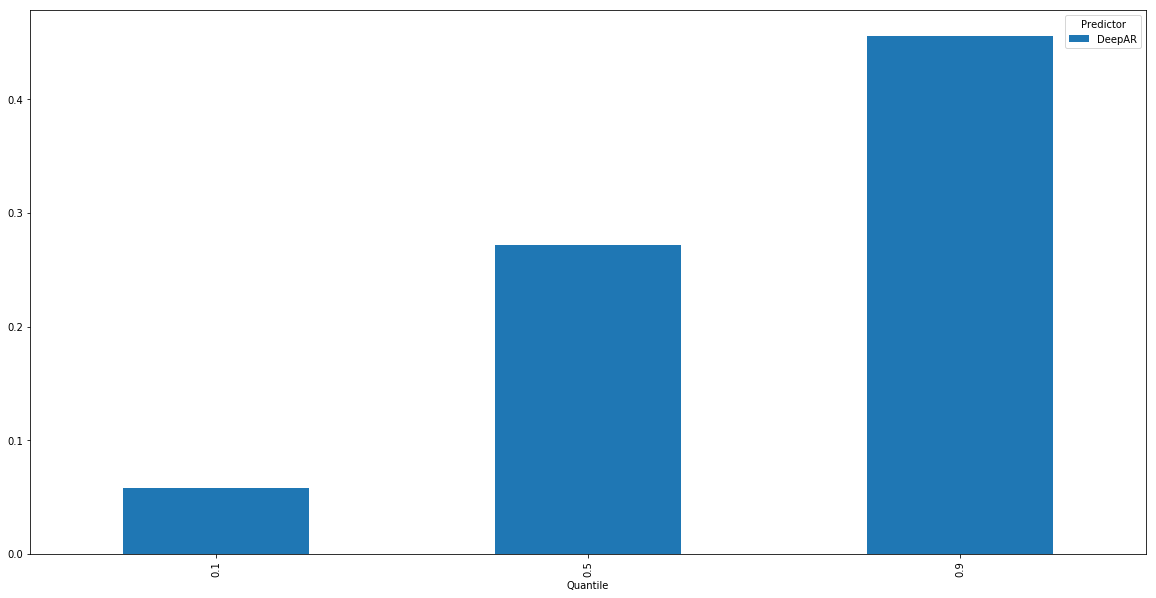

In [326]:
pd.concat([deep_ar_metrics]) \
    .pivot(index='Quantile', columns='Predictor', values='LossValue').plot.bar();

As we mentioned before, if you only have a handful of time series (in this case, only 1) with a small number of examples, the neural network models (DeepAR+) are not the best choice. Here, we clearly see that DeepAR+ behaves worse than Prophet in the case of a single time series. 

## Creating and Exporting Forecasts

Inside Amazon Forecast a Forecast is a rendered collection of all of your items, at every time interval, for all selected quantiles, for your given forecast horizon. This process takes the Predictor you just created and uses it to generate these inferences and to store them in a useful state. Once a Forecast exists within the service you can query it and obtain a JSON response or use another API call to export it to a CSV that is stored in S3. 

This tutorial will focus on the S3 Export as that is often an easy way to manually explore the data with many tools.

These again will take some time to complete after you have executed the cells so explore the console to see when they have completed.

To do that visit the Amazon Forecast Service page, then clck your Dataset Group, and then click `Forecasts` on the left. They will say `Create in progress...` initially and then `Active` when ready for export.

In [ ]:
#DeepAR+

deep_ar_forecastName = project + 'deep_ar_algo_forecast'
deep_ar_create_forecast_response = forecast.create_forecast(ForecastName=deep_ar_forecastName,
                                                           PredictorArn=predictor_arn_deep_ar)
deep_ar_forecast_arn = deep_ar_create_forecast_response['ForecastArn']
print(deep_ar_forecast_arn)

elapsed_time = 0
while True:
    forecastStatus = forecast.describe_forecast(ForecastArn=deep_ar_forecast_arn)['Status']
    print("Forecast Status: " + forecastStatus)
    print(elapsed_time)
    if forecastStatus != 'ACTIVE' and forecastStatus != 'CREATE_FAILED':
        sleep(30)
        elapsed_time = elapsed_time + 30
    else:
        break



arn:aws:forecast:us-east-1:144386903708:forecast/DataEngineeringImersionDayHourlydeep_ar_algo_forecast
Forecast Status: CREATE_PENDING
0
Forecast Status: CREATE_IN_PROGRESS
30
Forecast Status: CREATE_IN_PROGRESS
60
Forecast Status: CREATE_IN_PROGRESS
90
Forecast Status: CREATE_IN_PROGRESS
120
Forecast Status: CREATE_IN_PROGRESS
150
Forecast Status: CREATE_IN_PROGRESS
180
Forecast Status: CREATE_IN_PROGRESS
210
Forecast Status: CREATE_IN_PROGRESS
240
Forecast Status: CREATE_IN_PROGRESS
270
Forecast Status: CREATE_IN_PROGRESS
300
Forecast Status: CREATE_IN_PROGRESS
330
Forecast Status: CREATE_IN_PROGRESS
360
Forecast Status: CREATE_IN_PROGRESS
390
Forecast Status: CREATE_IN_PROGRESS
420
Forecast Status: CREATE_IN_PROGRESS
450
Forecast Status: CREATE_IN_PROGRESS
480
Forecast Status: CREATE_IN_PROGRESS
510
Forecast Status: CREATE_IN_PROGRESS
540
Forecast Status: CREATE_IN_PROGRESS
570
Forecast Status: CREATE_IN_PROGRESS
600
Forecast Status: CREATE_IN_PROGRESS
630
Forecast Status: CREATE_IN

Now go wait about **30 minutes** for this to complete in the console so that it can be exported and we can look for opportunities within the market.

In [328]:
deep_ar_path = "s3://" + bucket_name + "/DeepAR"
deep_ar_job_name = "dataengineering_deep_ar_algo_forecast"
forecast.create_forecast_export_job(ForecastExportJobName=deep_ar_job_name,
                                    ForecastArn=deep_ar_forecast_arn,
                                    Destination={
                                        "S3Config": {
                                            "Path": deep_ar_path,
                                            "RoleArn": role_arn
                                        }
                                    })

{'ForecastExportJobArn': 'arn:aws:forecast:us-east-1:144386903708:forecast-export-job/DataEngineeringImersionDayHourlydeep_ar_algo_forecast/dataengineering_deep_ar_algo_forecast',
 'ResponseMetadata': {'RequestId': '6dd14857-0bfd-432e-96d2-827f3208b0e4',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1',
   'date': 'Sat, 22 Feb 2020 01:45:06 GMT',
   'x-amzn-requestid': '6dd14857-0bfd-432e-96d2-827f3208b0e4',
   'content-length': '178',
   'connection': 'keep-alive'},
  'RetryAttempts': 0}}

This exporting process is another one of those items that will take **5 minutes** to complete. Just poll for progress in the console. From the earlier page where you saw the status turn `Active` for a Forecast, click it and you can see the progress of the export.

### Obtaining the Forecasts

At this point they are all exported into S3 but you need to obtain the results locally so we can explore them, the cells below will do that.

In [337]:


s3 = boto3.resource('s3')
poc_bucket = s3.Bucket(bucket_name)
deep_ar_filename = ""
deep_ar_files = list(poc_bucket.objects.filter(Prefix="DeepAR"))
for file in deep_ar_files:
    #There will be a collection of CSVs if the forecast is large, modify this to go get them all
    if "csv" in file.key:
        deep_ar_filename = file.key.split('/')[1]
        s3.Bucket(bucket_name).download_file(file.key, data_dir+"/"+deep_ar_filename)
print(deep_ar_filename)


dataengineering_deep_ar_algo_forecast_2020-02-22T01-46-22Z_part0.csv


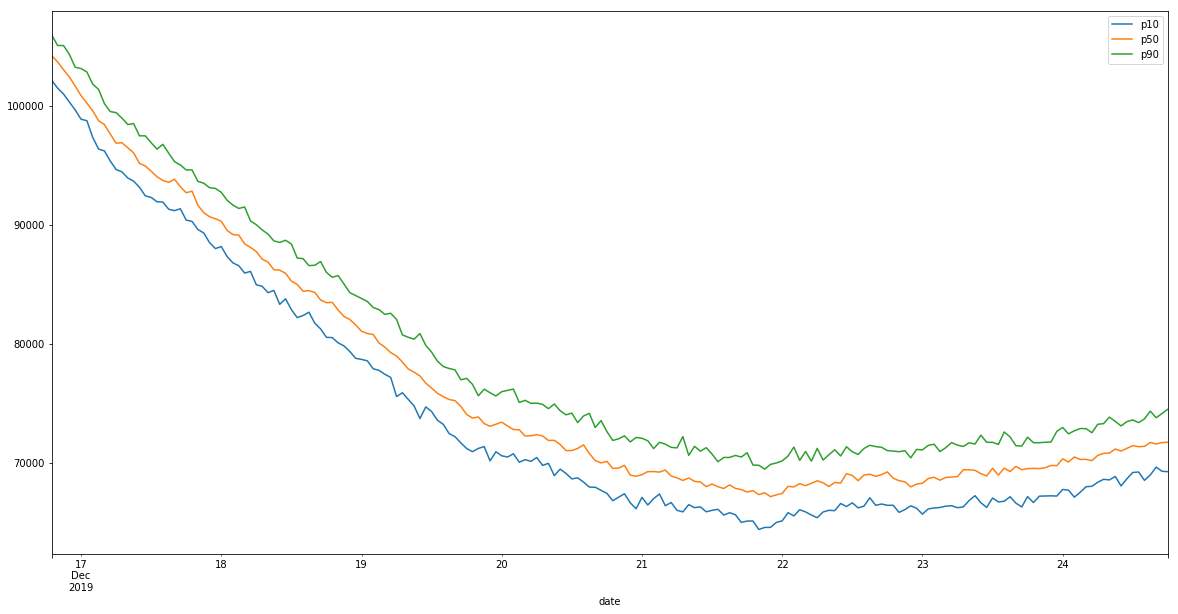

In [353]:
# DeepAR+ Eval

deep_ar_predicts = pd.read_csv(data_dir+"/"+deep_ar_filename)
deep_ar_predicts.sample()

# Remove the timezone

deep_ar_predicts['date'] = pd.to_datetime(deep_ar_predicts['date'])
deep_ar_predicts['date'] = deep_ar_predicts['date'].dt.tz_convert(None)
deep_ar_predicts.set_index('date',inplace=True)
deep_ar_predicts = deep_ar_predicts[['p10','p50','p90']]

deep_ar_predicts.plot()
# Finally let us join the dataframes together




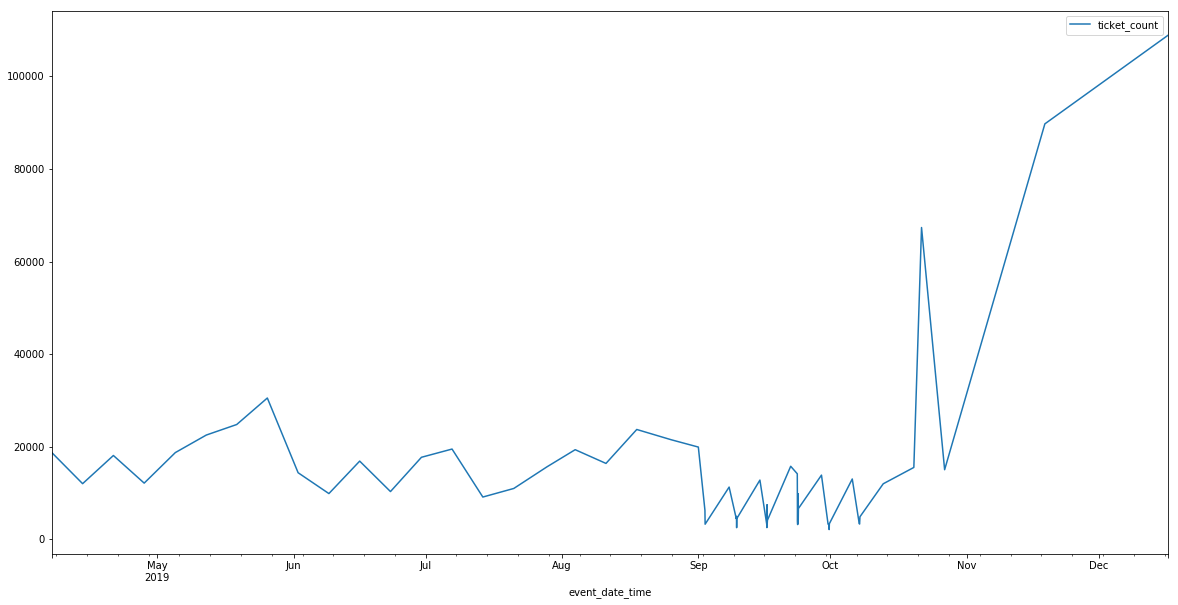

In [339]:
ticket_df.plot()

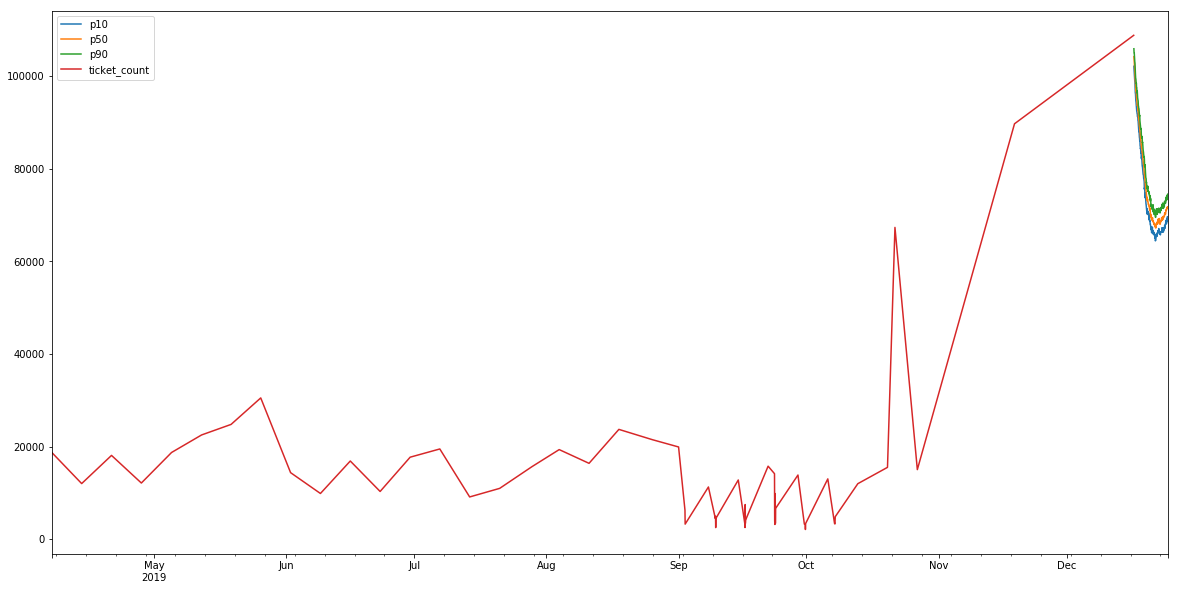

In [382]:
# Lets make a copy of the 
visualization = ticket_df.copy()
deeparvis = deep_ar_predicts.copy()

visualization = deeparvis.join(visualization, how='outer')
visualization.plot()

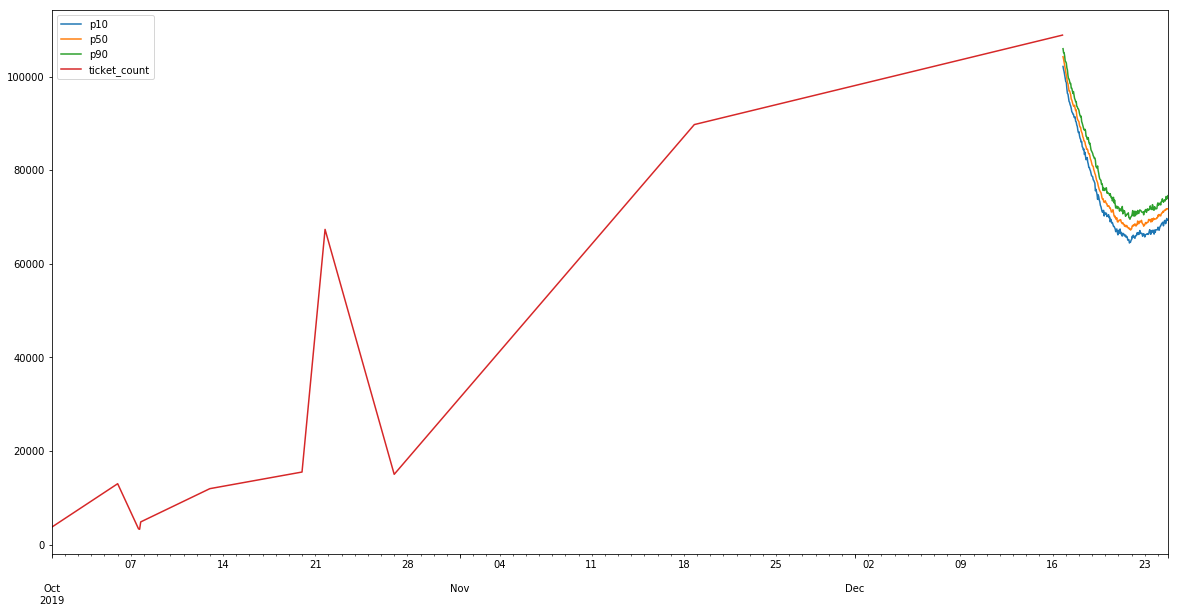

In [384]:
visualization['2019-10-01 00:00:00':].plot()

In [380]:
visualization['2019-12-16 00:00:00':'2019-12-19 00:00:00']

,p10,p50,p90,ticket_count
2019-12-16 00:00:00,NaN,NaN,NaN,108342.254844
2019-12-16 01:00:00,NaN,NaN,NaN,108370.740686
2019-12-16 02:00:00,NaN,NaN,NaN,108399.226528
2019-12-16 03:00:00,NaN,NaN,NaN,108427.712370
2019-12-16 04:00:00,NaN,NaN,NaN,108456.198212
2019-12-16 05:00:00,NaN,NaN,NaN,108484.684054
2019-12-16 06:00:00,NaN,NaN,NaN,108513.169896
2019-12-16 07:00:00,NaN,NaN,NaN,108541.655738
2019-12-16 08:00:00,NaN,NaN,NaN,108570.141580
2019-12-16 09:00:00,NaN,NaN,NaN,108598.627422
